In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import torch
import numpy as np
import json
from tqdm.auto import tqdm

import os
import sys
import random
sys.path.append('..')

from relations import estimate
from util import model_utils
from dsets.counterfact import CounterFactDataset
from util import nethook
from relations import evaluate

In [3]:
MODEL_NAME = "EleutherAI/gpt-j-6B"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=True, torch_dtype=torch.float16)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token

In [25]:
rid = "P17"

with open("best_performing_cases__relationwise__gpt-j.json") as f:
    best_performing = json.load(f)[rid]

len(best_performing)

10

In [26]:
from dsets.counterfact import CounterFactDataset
counterfact = CounterFactDataset("../data/")

cf_relation = [
    c["requested_rewrite"]
    for c in counterfact
    if c["requested_rewrite"]["relation_id"] == rid
]
print(
    f"{rid} >> number of requests in counterfact = {len(cf_relation)}"
)

Loaded dataset with 21919 elements
P17 >> number of requests in counterfact = 875


In [29]:
model_predict_ok = evaluate.filter_correct_predictions_by_model(
    model,
    tokenizer,
    "{} is located in the country of",
    cf_relation,
)

  0%|          | 0/875 [00:00<?, ?it/s]

In [30]:
len(model_predict_ok)

406

In [83]:
prompts = [
    "{}",
    "{} is located in the country of",
    "{} is in",
    "The country where {} is located in is",
    "{} can be found in",
    "{} is located within the confines of"
]

In [84]:
[p.replace("{}", "subject").replace(" ", "_")+"__country" for p in prompts]

['subject__country',
 'subject_is_located_in_the_country_of__country',
 'subject_is_in__country',
 'The_country_where_subject_is_located_in_is__country',
 'subject_can_be_found_in__country',
 'subject_is_located_within_the_confines_of__country']

## Calculate Jacobians and biases

In [85]:
def get_averaged_JB(top_performers, relation_prompt, num_icl = 3, calculate_at_lnf = False):
    try:
        jbs = []
        for s, s_idx, o in tqdm(top_performers):
            others = set(top_performers) - {(s, s_idx, o)}
            others = random.sample(list(others), k = min(num_icl, len(list(others)))) 
            prompt = ""
            prompt += "\n".join(relation_prompt.format(s_other) + f" {o_other}" for s_other, idx_other, o_other in others) + "\n"
            prompt += relation_prompt
            print("subject: ", s)
            print(prompt)

            jb = estimate.estimate_relation_operator(
                model, tokenizer,
                s, prompt,
                subject_token_index= s_idx,
                layer = 15,
                device = model.device,
                # calculate_at_lnf = calculate_at_lnf
                # layer_name_format = "model.decoder.layers.{}",
                # ln_f_name = "model.decoder.final_layer_norm",
                # n_layer_field = "num_hidden_layers"
            )
            print(jb.weight.norm(), jb.bias.norm())
            print()
            jbs.append(jb)
        
        weight = torch.stack([jb.weight for jb in jbs]).mean(dim=0)
        bias  = torch.stack([jb.bias for jb in jbs]).mean(dim=0)

        return weight, bias
    except RuntimeError as e:
        if(str(e).startswith("CUDA out of memory")):
            print("CUDA out of memory")
        if(num_icl > 1):
            num_icl -= 1
            print("trying with smaller icl >> ", num_icl)
            return get_averaged_JB(top_performers, relation_prompt, num_icl, calculate_at_lnf)
        else:
            raise Exception("RuntimeError >> can't calculate Jacobian with minimum number of icl examples")

def get_multiple_averaged_JB(top_performers, relation_prompt, N = 3, num_icl = 2, calculate_at_lnf = False):
    weights_and_biases = []
    sample_size = min(len(top_performers), num_icl + 2)
    for _ in tqdm(range(N)):
        cur_sample = random.sample(top_performers, k = sample_size)
        weight, bias = get_averaged_JB(cur_sample, relation_prompt, num_icl, calculate_at_lnf)
        weights_and_biases.append({
            'weight': weight,
            'bias'  : bias
        })
    return weights_and_biases

In [86]:
sample = [(b['subject'], b['sub_idx'], b['object']) for b in best_performing]

cache = []

for cur_prompt in prompts:
    weights_and_biases = get_multiple_averaged_JB(
        sample, 
        relation_prompt= cur_prompt, 
        N = 5, num_icl=3,
        calculate_at_lnf=False
    )

    result = {
        'relation_id': rid,
        'prompt': cur_prompt,
        'jb': weights_and_biases
    }

    cache.append(result)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Harnaut
Southern Savonia Finland
Umarex Germany
Sabratha Libya
{}
tensor(17.4219, device='cuda:0', dtype=torch.float16) tensor(252.7500, device='cuda:0', dtype=torch.float16)

subject:  Imperia
Sabratha Libya
Umarex Germany
Southern Savonia Finland
{}
tensor(5.3945, device='cuda:0', dtype=torch.float16) tensor(317.5000, device='cuda:0', dtype=torch.float16)

subject:  Southern Savonia
Sabratha Libya
Umarex Germany
Imperia Italy
{}
tensor(13.3906, device='cuda:0', dtype=torch.float16) tensor(307., device='cuda:0', dtype=torch.float16)

subject:  Umarex
Southern Savonia Finland
Sabratha Libya
Harnaut India
{}
tensor(23.5156, device='cuda:0', dtype=torch.float16) tensor(265.7500, device='cuda:0', dtype=torch.float16)

subject:  Sabratha
Umarex Germany
Southern Savonia Finland
Imperia Italy
{}
tensor(14.0234, device='cuda:0', dtype=torch.float16) tensor(318.7500, device='cuda:0', dtype=torch.float16)



  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Imperia
Ufa Russia
Umarex Germany
Eurostat Luxembourg
{}
tensor(4.5508, device='cuda:0', dtype=torch.float16) tensor(320.2500, device='cuda:0', dtype=torch.float16)

subject:  Southern Savonia
Eurostat Luxembourg
Ufa Russia
Imperia Italy
{}
tensor(15.2266, device='cuda:0', dtype=torch.float16) tensor(275., device='cuda:0', dtype=torch.float16)

subject:  Eurostat
Umarex Germany
Imperia Italy
Southern Savonia Finland
{}
tensor(8.5156, device='cuda:0', dtype=torch.float16) tensor(309., device='cuda:0', dtype=torch.float16)

subject:  Umarex
Imperia Italy
Southern Savonia Finland
Ufa Russia
{}
tensor(15.0703, device='cuda:0', dtype=torch.float16) tensor(359.5000, device='cuda:0', dtype=torch.float16)

subject:  Ufa
Southern Savonia Finland
Imperia Italy
Umarex Germany
{}
tensor(8.6250, device='cuda:0', dtype=torch.float16) tensor(294., device='cuda:0', dtype=torch.float16)



  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Marugame
Sabratha Libya
Umarex Germany
Ufa Russia
{}
tensor(26.4062, device='cuda:0', dtype=torch.float16) tensor(299.5000, device='cuda:0', dtype=torch.float16)

subject:  Southern Savonia
Sabratha Libya
Ufa Russia
Marugame Japan
{}
tensor(18.4062, device='cuda:0', dtype=torch.float16) tensor(264.5000, device='cuda:0', dtype=torch.float16)

subject:  Ufa
Umarex Germany
Sabratha Libya
Marugame Japan
{}
tensor(7.3398, device='cuda:0', dtype=torch.float16) tensor(297.7500, device='cuda:0', dtype=torch.float16)

subject:  Umarex
Sabratha Libya
Southern Savonia Finland
Ufa Russia
{}
tensor(15.4844, device='cuda:0', dtype=torch.float16) tensor(345.7500, device='cuda:0', dtype=torch.float16)

subject:  Sabratha
Southern Savonia Finland
Ufa Russia
Umarex Germany
{}
tensor(15.0703, device='cuda:0', dtype=torch.float16) tensor(333.7500, device='cuda:0', dtype=torch.float16)



  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Eurostat
Imperia Italy
Harnaut India
Marugame Japan
{}
tensor(10.2188, device='cuda:0', dtype=torch.float16) tensor(296., device='cuda:0', dtype=torch.float16)

subject:  Marugame
Harnaut India
Eurostat Luxembourg
Imperia Italy
{}
tensor(18.1719, device='cuda:0', dtype=torch.float16) tensor(312.2500, device='cuda:0', dtype=torch.float16)

subject:  Sabratha
Imperia Italy
Harnaut India
Eurostat Luxembourg
{}
tensor(16.3906, device='cuda:0', dtype=torch.float16) tensor(331.7500, device='cuda:0', dtype=torch.float16)

subject:  Harnaut
Eurostat Luxembourg
Sabratha Libya
Imperia Italy
{}
tensor(17.9375, device='cuda:0', dtype=torch.float16) tensor(273.5000, device='cuda:0', dtype=torch.float16)

subject:  Imperia
Harnaut India
Marugame Japan
Sabratha Libya
{}
tensor(8.8672, device='cuda:0', dtype=torch.float16) tensor(265.7500, device='cuda:0', dtype=torch.float16)



  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Imperia
Southern Savonia Finland
Haut Atlas Morocco
Marugame Japan
{}
tensor(6.1875, device='cuda:0', dtype=torch.float16) tensor(298., device='cuda:0', dtype=torch.float16)

subject:  Ufa
Southern Savonia Finland
Haut Atlas Morocco
Imperia Italy
{}
tensor(7.1914, device='cuda:0', dtype=torch.float16) tensor(330., device='cuda:0', dtype=torch.float16)

subject:  Haut Atlas
Marugame Japan
Southern Savonia Finland
Imperia Italy
{}
tensor(16.1875, device='cuda:0', dtype=torch.float16) tensor(286.7500, device='cuda:0', dtype=torch.float16)

subject:  Marugame
Imperia Italy
Haut Atlas Morocco
Ufa Russia
{}
tensor(27.2031, device='cuda:0', dtype=torch.float16) tensor(322., device='cuda:0', dtype=torch.float16)

subject:  Southern Savonia
Marugame Japan
Ufa Russia
Imperia Italy
{}
tensor(15.4766, device='cuda:0', dtype=torch.float16) tensor(263., device='cuda:0', dtype=torch.float16)



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Southern Savonia
Haut Atlas is located in the country of Morocco
Canada Live is located in the country of Canada
Ufa is located in the country of Russia
{} is located in the country of
tensor(10.7891, device='cuda:0', dtype=torch.float16) tensor(257., device='cuda:0', dtype=torch.float16)

subject:  Imperia
Canada Live is located in the country of Canada
Southern Savonia is located in the country of Finland
Haut Atlas is located in the country of Morocco
{} is located in the country of
tensor(3.5781, device='cuda:0', dtype=torch.float16) tensor(274.2500, device='cuda:0', dtype=torch.float16)

subject:  Haut Atlas
Southern Savonia is located in the country of Finland
Imperia is located in the country of Italy
Ufa is located in the country of Russia
{} is located in the country of
tensor(10.2734, device='cuda:0', dtype=torch.float16) tensor(305.5000, device='cuda:0', dtype=torch.float16)

subject:  Canada Live
Imperia is located in the country of Italy
Haut Atlas is located in 

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Southern Savonia
Eurostat is located in the country of Luxembourg
Haut Atlas is located in the country of Morocco
Imperia is located in the country of Italy
{} is located in the country of
tensor(11.5156, device='cuda:0', dtype=torch.float16) tensor(258.7500, device='cuda:0', dtype=torch.float16)

subject:  Sabratha
Imperia is located in the country of Italy
Haut Atlas is located in the country of Morocco
Southern Savonia is located in the country of Finland
{} is located in the country of
tensor(16., device='cuda:0', dtype=torch.float16) tensor(276.2500, device='cuda:0', dtype=torch.float16)

subject:  Eurostat
Haut Atlas is located in the country of Morocco
Southern Savonia is located in the country of Finland
Sabratha is located in the country of Libya
{} is located in the country of
tensor(11.2891, device='cuda:0', dtype=torch.float16) tensor(243.6250, device='cuda:0', dtype=torch.float16)

subject:  Imperia
Southern Savonia is located in the country of Finland
Eurostat i

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Canada Live
Harnaut is located in the country of India
Sabratha is located in the country of Libya
Eurostat is located in the country of Luxembourg
{} is located in the country of
tensor(18.3125, device='cuda:0', dtype=torch.float16) tensor(316., device='cuda:0', dtype=torch.float16)

subject:  Sabratha
Ufa is located in the country of Russia
Canada Live is located in the country of Canada
Eurostat is located in the country of Luxembourg
{} is located in the country of
tensor(15.3047, device='cuda:0', dtype=torch.float16) tensor(274.2500, device='cuda:0', dtype=torch.float16)

subject:  Harnaut
Eurostat is located in the country of Luxembourg
Ufa is located in the country of Russia
Canada Live is located in the country of Canada
{} is located in the country of
tensor(24.5469, device='cuda:0', dtype=torch.float16) tensor(275.5000, device='cuda:0', dtype=torch.float16)

subject:  Eurostat
Harnaut is located in the country of India
Ufa is located in the country of Russia
Canada 

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Eurostat
Harnaut is located in the country of India
Ufa is located in the country of Russia
Canada Live is located in the country of Canada
{} is located in the country of
tensor(12.7031, device='cuda:0', dtype=torch.float16) tensor(299.7500, device='cuda:0', dtype=torch.float16)

subject:  Umarex
Canada Live is located in the country of Canada
Harnaut is located in the country of India
Eurostat is located in the country of Luxembourg
{} is located in the country of
tensor(27.6875, device='cuda:0', dtype=torch.float16) tensor(319., device='cuda:0', dtype=torch.float16)

subject:  Harnaut
Umarex is located in the country of Germany
Ufa is located in the country of Russia
Canada Live is located in the country of Canada
{} is located in the country of
tensor(19.7812, device='cuda:0', dtype=torch.float16) tensor(296., device='cuda:0', dtype=torch.float16)

subject:  Canada Live
Ufa is located in the country of Russia
Harnaut is located in the country of India
Eurostat is located 

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Sabratha
Imperia is located in the country of Italy
Southern Savonia is located in the country of Finland
Marugame is located in the country of Japan
{} is located in the country of
tensor(16.7344, device='cuda:0', dtype=torch.float16) tensor(265.7500, device='cuda:0', dtype=torch.float16)

subject:  Southern Savonia
Imperia is located in the country of Italy
Ufa is located in the country of Russia
Marugame is located in the country of Japan
{} is located in the country of
tensor(12.7969, device='cuda:0', dtype=torch.float16) tensor(268., device='cuda:0', dtype=torch.float16)

subject:  Marugame
Ufa is located in the country of Russia
Southern Savonia is located in the country of Finland
Imperia is located in the country of Italy
{} is located in the country of
tensor(40.9375, device='cuda:0', dtype=torch.float16) tensor(227.6250, device='cuda:0', dtype=torch.float16)

subject:  Ufa
Imperia is located in the country of Italy
Southern Savonia is located in the country of Finla

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Eurostat
Canada Live is in Canada
Imperia is in Italy
Harnaut is in India
{} is in
tensor(12.8047, device='cuda:0', dtype=torch.float16) tensor(276.5000, device='cuda:0', dtype=torch.float16)

subject:  Haut Atlas
Harnaut is in India
Canada Live is in Canada
Eurostat is in Luxembourg
{} is in
tensor(17.2500, device='cuda:0', dtype=torch.float16) tensor(314.7500, device='cuda:0', dtype=torch.float16)

subject:  Harnaut
Canada Live is in Canada
Imperia is in Italy
Haut Atlas is in Morocco
{} is in
tensor(24.4844, device='cuda:0', dtype=torch.float16) tensor(303.5000, device='cuda:0', dtype=torch.float16)

subject:  Canada Live
Eurostat is in Luxembourg
Imperia is in Italy
Haut Atlas is in Morocco
{} is in
tensor(22.0312, device='cuda:0', dtype=torch.float16) tensor(352.5000, device='cuda:0', dtype=torch.float16)

subject:  Imperia
Canada Live is in Canada
Eurostat is in Luxembourg
Harnaut is in India
{} is in
tensor(7.1211, device='cuda:0', dtype=torch.float16) tensor(310.7500,

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Canada Live
Harnaut is in India
Ufa is in Russia
Umarex is in Germany
{} is in
tensor(17.7812, device='cuda:0', dtype=torch.float16) tensor(391.5000, device='cuda:0', dtype=torch.float16)

subject:  Haut Atlas
Umarex is in Germany
Canada Live is in Canada
Ufa is in Russia
{} is in
tensor(13.0703, device='cuda:0', dtype=torch.float16) tensor(382.7500, device='cuda:0', dtype=torch.float16)

subject:  Umarex
Canada Live is in Canada
Ufa is in Russia
Haut Atlas is in Morocco
{} is in
tensor(32.2812, device='cuda:0', dtype=torch.float16) tensor(305.2500, device='cuda:0', dtype=torch.float16)

subject:  Harnaut
Ufa is in Russia
Haut Atlas is in Morocco
Umarex is in Germany
{} is in
tensor(13.8047, device='cuda:0', dtype=torch.float16) tensor(335.5000, device='cuda:0', dtype=torch.float16)

subject:  Ufa
Canada Live is in Canada
Haut Atlas is in Morocco
Umarex is in Germany
{} is in
tensor(2.7969, device='cuda:0', dtype=torch.float16) tensor(315.5000, device='cuda:0', dtype=torch.fl

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Marugame
Ufa is in Russia
Canada Live is in Canada
Harnaut is in India
{} is in
tensor(45.9062, device='cuda:0', dtype=torch.float16) tensor(257.7500, device='cuda:0', dtype=torch.float16)

subject:  Ufa
Umarex is in Germany
Harnaut is in India
Marugame is in Japan
{} is in
tensor(5.2305, device='cuda:0', dtype=torch.float16) tensor(286.7500, device='cuda:0', dtype=torch.float16)

subject:  Canada Live
Harnaut is in India
Umarex is in Germany
Marugame is in Japan
{} is in
tensor(19.5000, device='cuda:0', dtype=torch.float16) tensor(386.2500, device='cuda:0', dtype=torch.float16)

subject:  Umarex
Canada Live is in Canada
Marugame is in Japan
Harnaut is in India
{} is in
tensor(26.1719, device='cuda:0', dtype=torch.float16) tensor(354.7500, device='cuda:0', dtype=torch.float16)

subject:  Harnaut
Ufa is in Russia
Marugame is in Japan
Umarex is in Germany
{} is in
tensor(15.3438, device='cuda:0', dtype=torch.float16) tensor(313.5000, device='cuda:0', dtype=torch.float16)



  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Imperia
Ufa is in Russia
Eurostat is in Luxembourg
Harnaut is in India
{} is in
tensor(8.8438, device='cuda:0', dtype=torch.float16) tensor(276., device='cuda:0', dtype=torch.float16)

subject:  Harnaut
Imperia is in Italy
Ufa is in Russia
Canada Live is in Canada
{} is in
tensor(23.1094, device='cuda:0', dtype=torch.float16) tensor(334.7500, device='cuda:0', dtype=torch.float16)

subject:  Canada Live
Harnaut is in India
Eurostat is in Luxembourg
Ufa is in Russia
{} is in
tensor(19.7500, device='cuda:0', dtype=torch.float16) tensor(354.2500, device='cuda:0', dtype=torch.float16)

subject:  Eurostat
Harnaut is in India
Canada Live is in Canada
Ufa is in Russia
{} is in
tensor(12.1406, device='cuda:0', dtype=torch.float16) tensor(263.7500, device='cuda:0', dtype=torch.float16)

subject:  Ufa
Eurostat is in Luxembourg
Canada Live is in Canada
Imperia is in Italy
{} is in
tensor(4.4766, device='cuda:0', dtype=torch.float16) tensor(301.5000, device='cuda:0', dtype=torch.float16)


  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Imperia
Umarex is in Germany
Marugame is in Japan
Haut Atlas is in Morocco
{} is in
tensor(4.9414, device='cuda:0', dtype=torch.float16) tensor(298.2500, device='cuda:0', dtype=torch.float16)

subject:  Umarex
Canada Live is in Canada
Imperia is in Italy
Marugame is in Japan
{} is in
tensor(24.8438, device='cuda:0', dtype=torch.float16) tensor(343.2500, device='cuda:0', dtype=torch.float16)

subject:  Marugame
Haut Atlas is in Morocco
Canada Live is in Canada
Imperia is in Italy
{} is in
tensor(45.1875, device='cuda:0', dtype=torch.float16) tensor(268.7500, device='cuda:0', dtype=torch.float16)

subject:  Haut Atlas
Canada Live is in Canada
Imperia is in Italy
Marugame is in Japan
{} is in
tensor(16.0938, device='cuda:0', dtype=torch.float16) tensor(343.2500, device='cuda:0', dtype=torch.float16)

subject:  Canada Live
Umarex is in Germany
Marugame is in Japan
Imperia is in Italy
{} is in
tensor(20.6250, device='cuda:0', dtype=torch.float16) tensor(364., device='cuda:0', dtyp

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Eurostat
The country where Imperia is located in is Italy
The country where Canada Live is located in is Canada
The country where Ufa is located in is Russia
The country where {} is located in is
tensor(18.8594, device='cuda:0', dtype=torch.float16) tensor(275.5000, device='cuda:0', dtype=torch.float16)

subject:  Ufa
The country where Imperia is located in is Italy
The country where Eurostat is located in is Luxembourg
The country where Canada Live is located in is Canada
The country where {} is located in is
tensor(28.0781, device='cuda:0', dtype=torch.float16) tensor(293.7500, device='cuda:0', dtype=torch.float16)

subject:  Umarex
The country where Imperia is located in is Italy
The country where Canada Live is located in is Canada
The country where Eurostat is located in is Luxembourg
The country where {} is located in is
tensor(13.5781, device='cuda:0', dtype=torch.float16) tensor(342.5000, device='cuda:0', dtype=torch.float16)

subject:  Canada Live
The country where E

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Ufa
The country where Marugame is located in is Japan
The country where Harnaut is located in is India
The country where Southern Savonia is located in is Finland
The country where {} is located in is
tensor(30.5156, device='cuda:0', dtype=torch.float16) tensor(274.2500, device='cuda:0', dtype=torch.float16)

subject:  Harnaut
The country where Southern Savonia is located in is Finland
The country where Sabratha is located in is Libya
The country where Marugame is located in is Japan
The country where {} is located in is
tensor(17.4531, device='cuda:0', dtype=torch.float16) tensor(278.5000, device='cuda:0', dtype=torch.float16)

subject:  Southern Savonia
The country where Harnaut is located in is India
The country where Marugame is located in is Japan
The country where Ufa is located in is Russia
The country where {} is located in is
tensor(27.0781, device='cuda:0', dtype=torch.float16) tensor(263., device='cuda:0', dtype=torch.float16)

subject:  Sabratha
The country where 

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Haut Atlas
The country where Eurostat is located in is Luxembourg
The country where Ufa is located in is Russia
The country where Sabratha is located in is Libya
The country where {} is located in is
tensor(27.2344, device='cuda:0', dtype=torch.float16) tensor(287.2500, device='cuda:0', dtype=torch.float16)

subject:  Eurostat
The country where Sabratha is located in is Libya
The country where Harnaut is located in is India
The country where Haut Atlas is located in is Morocco
The country where {} is located in is
tensor(20.5781, device='cuda:0', dtype=torch.float16) tensor(257., device='cuda:0', dtype=torch.float16)

subject:  Sabratha
The country where Ufa is located in is Russia
The country where Harnaut is located in is India
The country where Haut Atlas is located in is Morocco
The country where {} is located in is
tensor(32.9375, device='cuda:0', dtype=torch.float16) tensor(277.7500, device='cuda:0', dtype=torch.float16)

subject:  Harnaut
The country where Haut Atlas i

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Imperia
The country where Sabratha is located in is Libya
The country where Umarex is located in is Germany
The country where Haut Atlas is located in is Morocco
The country where {} is located in is
tensor(13.6094, device='cuda:0', dtype=torch.float16) tensor(348.2500, device='cuda:0', dtype=torch.float16)

subject:  Haut Atlas
The country where Imperia is located in is Italy
The country where Sabratha is located in is Libya
The country where Umarex is located in is Germany
The country where {} is located in is
tensor(20.3438, device='cuda:0', dtype=torch.float16) tensor(333.7500, device='cuda:0', dtype=torch.float16)

subject:  Sabratha
The country where Umarex is located in is Germany
The country where Haut Atlas is located in is Morocco
The country where Ufa is located in is Russia
The country where {} is located in is
tensor(31.8750, device='cuda:0', dtype=torch.float16) tensor(275., device='cuda:0', dtype=torch.float16)

subject:  Umarex
The country where Haut Atlas is 

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Canada Live
The country where Imperia is located in is Italy
The country where Harnaut is located in is India
The country where Haut Atlas is located in is Morocco
The country where {} is located in is
tensor(5.4180, device='cuda:0', dtype=torch.float16) tensor(335.5000, device='cuda:0', dtype=torch.float16)

subject:  Eurostat
The country where Harnaut is located in is India
The country where Haut Atlas is located in is Morocco
The country where Canada Live is located in is Canada
The country where {} is located in is
tensor(17.1094, device='cuda:0', dtype=torch.float16) tensor(281., device='cuda:0', dtype=torch.float16)

subject:  Harnaut
The country where Haut Atlas is located in is Morocco
The country where Canada Live is located in is Canada
The country where Eurostat is located in is Luxembourg
The country where {} is located in is
tensor(18.5781, device='cuda:0', dtype=torch.float16) tensor(342., device='cuda:0', dtype=torch.float16)

subject:  Haut Atlas
The country w

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Sabratha
Haut Atlas can be found in Morocco
Canada Live can be found in Canada
Marugame can be found in Japan
{} can be found in
tensor(16.7656, device='cuda:0', dtype=torch.float16) tensor(274.7500, device='cuda:0', dtype=torch.float16)

subject:  Haut Atlas
Umarex can be found in Germany
Sabratha can be found in Libya
Canada Live can be found in Canada
{} can be found in
tensor(9.0781, device='cuda:0', dtype=torch.float16) tensor(335., device='cuda:0', dtype=torch.float16)

subject:  Canada Live
Sabratha can be found in Libya
Umarex can be found in Germany
Marugame can be found in Japan
{} can be found in
tensor(20.2500, device='cuda:0', dtype=torch.float16) tensor(377.5000, device='cuda:0', dtype=torch.float16)

subject:  Marugame
Haut Atlas can be found in Morocco
Umarex can be found in Germany
Canada Live can be found in Canada
{} can be found in
tensor(26.4531, device='cuda:0', dtype=torch.float16) tensor(296., device='cuda:0', dtype=torch.float16)

subject:  Umarex
Mar

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Southern Savonia
Sabratha can be found in Libya
Imperia can be found in Italy
Eurostat can be found in Luxembourg
{} can be found in
tensor(15.8906, device='cuda:0', dtype=torch.float16) tensor(248., device='cuda:0', dtype=torch.float16)

subject:  Imperia
Canada Live can be found in Canada
Eurostat can be found in Luxembourg
Southern Savonia can be found in Finland
{} can be found in
tensor(5.2734, device='cuda:0', dtype=torch.float16) tensor(283.2500, device='cuda:0', dtype=torch.float16)

subject:  Sabratha
Southern Savonia can be found in Finland
Canada Live can be found in Canada
Eurostat can be found in Luxembourg
{} can be found in
tensor(16.1875, device='cuda:0', dtype=torch.float16) tensor(292., device='cuda:0', dtype=torch.float16)

subject:  Canada Live
Southern Savonia can be found in Finland
Sabratha can be found in Libya
Eurostat can be found in Luxembourg
{} can be found in
tensor(20.0625, device='cuda:0', dtype=torch.float16) tensor(343.5000, device='cuda:0', 

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Marugame
Haut Atlas can be found in Morocco
Harnaut can be found in India
Canada Live can be found in Canada
{} can be found in
tensor(32.0938, device='cuda:0', dtype=torch.float16) tensor(277., device='cuda:0', dtype=torch.float16)

subject:  Haut Atlas
Harnaut can be found in India
Eurostat can be found in Luxembourg
Marugame can be found in Japan
{} can be found in
tensor(11.0625, device='cuda:0', dtype=torch.float16) tensor(292.5000, device='cuda:0', dtype=torch.float16)

subject:  Eurostat
Harnaut can be found in India
Marugame can be found in Japan
Canada Live can be found in Canada
{} can be found in
tensor(12.1328, device='cuda:0', dtype=torch.float16) tensor(318.5000, device='cuda:0', dtype=torch.float16)

subject:  Canada Live
Haut Atlas can be found in Morocco
Harnaut can be found in India
Eurostat can be found in Luxembourg
{} can be found in
tensor(20.5938, device='cuda:0', dtype=torch.float16) tensor(369.5000, device='cuda:0', dtype=torch.float16)

subject:  Har

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Harnaut
Eurostat can be found in Luxembourg
Umarex can be found in Germany
Haut Atlas can be found in Morocco
{} can be found in
tensor(14.8906, device='cuda:0', dtype=torch.float16) tensor(334.7500, device='cuda:0', dtype=torch.float16)

subject:  Sabratha
Harnaut can be found in India
Haut Atlas can be found in Morocco
Umarex can be found in Germany
{} can be found in
tensor(10.7656, device='cuda:0', dtype=torch.float16) tensor(293., device='cuda:0', dtype=torch.float16)

subject:  Haut Atlas
Umarex can be found in Germany
Harnaut can be found in India
Sabratha can be found in Libya
{} can be found in
tensor(7.5352, device='cuda:0', dtype=torch.float16) tensor(309.2500, device='cuda:0', dtype=torch.float16)

subject:  Umarex
Sabratha can be found in Libya
Haut Atlas can be found in Morocco
Harnaut can be found in India
{} can be found in
tensor(20.3906, device='cuda:0', dtype=torch.float16) tensor(328.2500, device='cuda:0', dtype=torch.float16)

subject:  Eurostat
Haut Atla

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Marugame
Haut Atlas can be found in Morocco
Harnaut can be found in India
Eurostat can be found in Luxembourg
{} can be found in
tensor(30.4375, device='cuda:0', dtype=torch.float16) tensor(255.3750, device='cuda:0', dtype=torch.float16)

subject:  Eurostat
Marugame can be found in Japan
Harnaut can be found in India
Haut Atlas can be found in Morocco
{} can be found in
tensor(9.6328, device='cuda:0', dtype=torch.float16) tensor(261., device='cuda:0', dtype=torch.float16)

subject:  Harnaut
Sabratha can be found in Libya
Eurostat can be found in Luxembourg
Marugame can be found in Japan
{} can be found in
tensor(31.0156, device='cuda:0', dtype=torch.float16) tensor(230.3750, device='cuda:0', dtype=torch.float16)

subject:  Sabratha
Marugame can be found in Japan
Haut Atlas can be found in Morocco
Eurostat can be found in Luxembourg
{} can be found in
tensor(15.9453, device='cuda:0', dtype=torch.float16) tensor(267.7500, device='cuda:0', dtype=torch.float16)

subject:  Haut At

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Sabratha
Marugame is located within the confines of Japan
Harnaut is located within the confines of India
Southern Savonia is located within the confines of Finland
{} is located within the confines of
tensor(20.2031, device='cuda:0', dtype=torch.float16) tensor(272., device='cuda:0', dtype=torch.float16)

subject:  Imperia
Sabratha is located within the confines of Libya
Southern Savonia is located within the confines of Finland
Marugame is located within the confines of Japan
{} is located within the confines of
tensor(7.4414, device='cuda:0', dtype=torch.float16) tensor(265.7500, device='cuda:0', dtype=torch.float16)

subject:  Southern Savonia
Sabratha is located within the confines of Libya
Marugame is located within the confines of Japan
Harnaut is located within the confines of India
{} is located within the confines of
tensor(16.0469, device='cuda:0', dtype=torch.float16) tensor(271.2500, device='cuda:0', dtype=torch.float16)

subject:  Marugame
Sabratha is located wi

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Eurostat
Southern Savonia is located within the confines of Finland
Marugame is located within the confines of Japan
Haut Atlas is located within the confines of Morocco
{} is located within the confines of
tensor(11.4844, device='cuda:0', dtype=torch.float16) tensor(262.7500, device='cuda:0', dtype=torch.float16)

subject:  Southern Savonia
Eurostat is located within the confines of Luxembourg
Canada Live is located within the confines of Canada
Marugame is located within the confines of Japan
{} is located within the confines of
tensor(11.6328, device='cuda:0', dtype=torch.float16) tensor(278.7500, device='cuda:0', dtype=torch.float16)

subject:  Marugame
Eurostat is located within the confines of Luxembourg
Southern Savonia is located within the confines of Finland
Canada Live is located within the confines of Canada
{} is located within the confines of
tensor(41.2812, device='cuda:0', dtype=torch.float16) tensor(244.1250, device='cuda:0', dtype=torch.float16)

subject:  C

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Canada Live
Imperia is located within the confines of Italy
Umarex is located within the confines of Germany
Sabratha is located within the confines of Libya
{} is located within the confines of
tensor(19.2656, device='cuda:0', dtype=torch.float16) tensor(333., device='cuda:0', dtype=torch.float16)

subject:  Imperia
Sabratha is located within the confines of Libya
Marugame is located within the confines of Japan
Canada Live is located within the confines of Canada
{} is located within the confines of
tensor(3.9570, device='cuda:0', dtype=torch.float16) tensor(271.7500, device='cuda:0', dtype=torch.float16)

subject:  Umarex
Imperia is located within the confines of Italy
Marugame is located within the confines of Japan
Sabratha is located within the confines of Libya
{} is located within the confines of
tensor(19.2188, device='cuda:0', dtype=torch.float16) tensor(307.5000, device='cuda:0', dtype=torch.float16)

subject:  Marugame
Sabratha is located within the confines of Li

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Southern Savonia
Imperia is located within the confines of Italy
Haut Atlas is located within the confines of Morocco
Sabratha is located within the confines of Libya
{} is located within the confines of
tensor(13.8984, device='cuda:0', dtype=torch.float16) tensor(263.5000, device='cuda:0', dtype=torch.float16)

subject:  Umarex
Imperia is located within the confines of Italy
Sabratha is located within the confines of Libya
Southern Savonia is located within the confines of Finland
{} is located within the confines of
tensor(18.2969, device='cuda:0', dtype=torch.float16) tensor(341., device='cuda:0', dtype=torch.float16)

subject:  Sabratha
Umarex is located within the confines of Germany
Imperia is located within the confines of Italy
Haut Atlas is located within the confines of Morocco
{} is located within the confines of
tensor(18.3906, device='cuda:0', dtype=torch.float16) tensor(257.2500, device='cuda:0', dtype=torch.float16)

subject:  Haut Atlas
Southern Savonia is loc

  0%|          | 0/5 [00:00<?, ?it/s]

subject:  Harnaut
Marugame is located within the confines of Japan
Ufa is located within the confines of Russia
Eurostat is located within the confines of Luxembourg
{} is located within the confines of
tensor(25.7031, device='cuda:0', dtype=torch.float16) tensor(250.3750, device='cuda:0', dtype=torch.float16)

subject:  Marugame
Ufa is located within the confines of Russia
Harnaut is located within the confines of India
Sabratha is located within the confines of Libya
{} is located within the confines of
tensor(41.7188, device='cuda:0', dtype=torch.float16) tensor(223., device='cuda:0', dtype=torch.float16)

subject:  Ufa
Eurostat is located within the confines of Luxembourg
Harnaut is located within the confines of India
Sabratha is located within the confines of Libya
{} is located within the confines of
tensor(4.5586, device='cuda:0', dtype=torch.float16) tensor(277.5000, device='cuda:0', dtype=torch.float16)

subject:  Eurostat
Ufa is located within the confines of Russia
Harnaut 

In [89]:
np.savez(
    f"jb_with_different_prompting/{rid}.npz", 
    jacobians = cache, 
    allow_pickle = True
)

In [91]:
# cache[0]['jb'][0]['weight']

## Analysis

In [106]:
cached_jb = np.load(
    f"jb_with_different_prompting/{rid}.npz",
    allow_pickle=True
)["jacobians"]

{}  >>  5
{} is located in the country of  >>  5
{} is in  >>  5
The country where {} is located in is  >>  5
{} can be found in  >>  5
{} is located within the confines of  >>  5


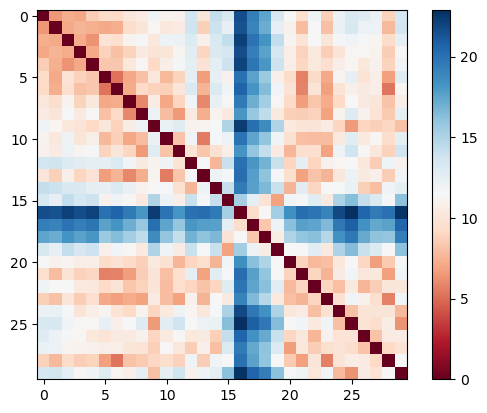

In [173]:
import matplotlib.pyplot as plt

j_collection = []

for i in range(len(cached_jb)):
    # if(i == 3):
    #     continue
    batch = cached_jb[i]
    print(batch['prompt'], " >> ", len(batch['jb']))
    j_collection += [b['weight'] for b in batch['jb']]
    # cur_batch = torch.stack([b['weight'] for b in batch['jb']])
    # print(cur_batch.shape)


dist_map = torch.zeros(len(j_collection), len(j_collection))
for fst in range(len(j_collection)):
    for scd in range(len(j_collection)):
        dist_map[fst][scd] = torch.dist(j_collection[fst], j_collection[scd])
    
img = plt.imshow(
    dist_map, cmap='RdBu', interpolation='nearest', 
    # vmin = -limit, vmax = limit
)
plt.colorbar(img, orientation='vertical')

In [174]:
objects = [c['requested_rewrite'] for c in counterfact if c["requested_rewrite"]['relation_id'] == rid]
objects = [" "+ o['target_true']['str'] for o in objects]
objects = list(set(objects))
print("unique objects: ", len(objects), objects[0:5])

unique objects:  95 [' Uganda', ' Estonia', ' Fiji', ' Russia', ' Australia']


/home/local_arnab/Codes/relations/scan-for-best/../relations/corner.py:159: UserWarning: 
                model.dtype == torch.float16
                the unembedder head will be typecasted to float32 in order to avoid precision underflows.
                
  warnings.warn(


transformer.ln_f.weight torch.Size([4096]) torch.float32
transformer.ln_f.bias torch.Size([4096]) torch.float32
lm_head.weight torch.Size([50400, 4096]) torch.float32
lm_head.bias torch.Size([50400]) torch.float32
initial representation:  [(' department', 10.488), (' ever', 9.867), (' Edge', 9.805), (' {', 9.294), ('",', 9.135)]
torch.float16


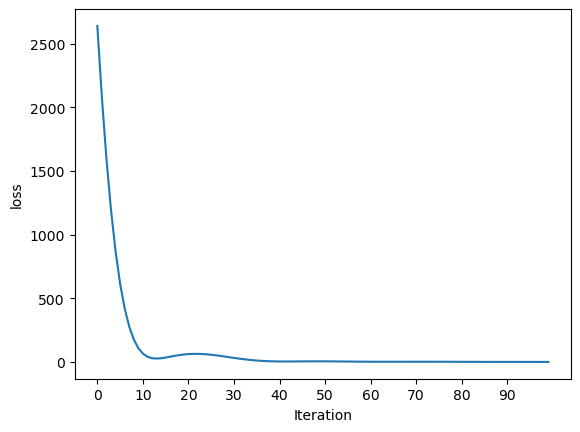

final representation:  [(' Ukraine', 51.969), (' Nigeria', 51.969), (' Cyprus', 51.812), (' Belgium', 51.812), (' Thailand', 51.594)]
50.6875


In [175]:
from relations.corner import CornerEstimator

corner_estimator = CornerEstimator(model=model, tokenizer=tokenizer)
grad_dsc_corner = corner_estimator.estimate_corner_with_gradient_descent(
    objects, target_logit_value=50, verbose=True
)
print(grad_dsc_corner.norm().item())

In [200]:
mean_jacobian = torch.stack(j_collection).mean(dim=0)
std_jacobian = torch.stack(j_collection).std(dim=0)

In [201]:
def visualize_matrix(weight, limit_dim = 100):
    weight = torch.stack([w[:limit_dim] for w in weight[:limit_dim]]).cpu()
    limit = max(abs(weight.min().item()), abs(weight.max().item()))
    img = plt.imshow(
        weight,
        cmap='RdBu', interpolation='nearest', 
        vmin = -limit, vmax = limit
    )
    plt.colorbar(img, orientation='vertical')

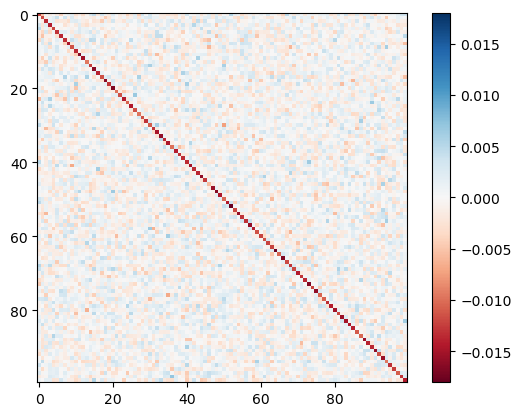

In [202]:
visualize_matrix(mean_jacobian)

In [203]:
relation_operator = estimate.RelationOperator(
    model = model,
    tokenizer = tokenizer,
    relation = '{} is located in the country of',
    layer = 15,
    weight = mean_jacobian,
    bias = grad_dsc_corner
)

In [204]:
precision, ret_dict = evaluate.evaluate(
    relation_id="P17",
    relation_operator= relation_operator,
    precision_at=3,
    validation_set= [
        (c["subject"], -1, c["target_true"]["str"]) 
        for c in model_predict_ok
    ]
)
precision

validating on 406 subject --> object associations


  0%|          | 0/406 [00:00<?, ?it/s]

0.8497536945812808

In [229]:
relation_operator = estimate.RelationOperator(
    model = model,
    tokenizer = tokenizer,
    relation = '{} is located in the country of',
    layer = 15,
    weight = torch.eye(mean_jacobian.shape[0]).to(model.dtype).to(model.device),
    bias = grad_dsc_corner
)

precision, ret_dict = evaluate.evaluate(
    relation_id="P17",
    relation_operator= relation_operator,
    precision_at=3,
    validation_set= [
        (c["subject"], -1, c["target_true"]["str"]) 
        for c in model_predict_ok
    ]
)
precision

validating on 406 subject --> object associations


  0%|          | 0/406 [00:00<?, ?it/s]

0.8694581280788177

In [218]:
def low_rank_approximation(weight, rank = 10):
    typecache = weight.dtype
    weight = weight.to(torch.float32)
    svd = weight.svd()
    wgt_est = torch.zeros(weight.shape).to(weight.device)
    for i in range(rank):
        wgt_est += svd.S[i] * (svd.U[:, i][None].T @ svd.V[:, i][None])
    # print(f"approximation error ==> {torch.dist(weight, wgt_est)}")
    approx_err = torch.dist(weight, wgt_est)
    print(f"rank {rank} >> ", approx_err)
    weight = weight.to(typecache)
    return wgt_est.to(typecache)

In [223]:
# ranks = range(1, 100)
# approx_errors = []
# for rank in tqdm(ranks):
#     jacobian_approx = low_rank_approximation(mean_jacobian, rank = rank)
#     err = torch.dist(jacobian_approx, mean_jacobian)
#     approx_errors.append(err)

# plt.plot([err.item() for err in approx_errors])

rank 10 >>  tensor(7.3727, device='cuda:0')


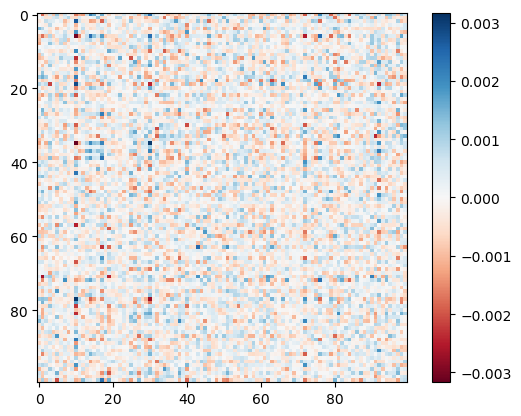

In [227]:
jacobian_approx = low_rank_approximation(mean_jacobian, rank = 10)
visualize_matrix(jacobian_approx)

In [228]:
relation_operator_approx = estimate.RelationOperator(
    model = model,
    tokenizer = tokenizer,
    relation = '{} is located in the country of',
    layer = 15,
    weight = jacobian_approx,
    bias = grad_dsc_corner
)

precision, ret_dict = evaluate.evaluate(
    relation_id="P17",
    relation_operator= relation_operator_approx,
    precision_at=3,
    validation_set= [
        (c["subject"], -1, c["target_true"]["str"]) 
        for c in model_predict_ok
    ]
)
precision

validating on 406 subject --> object associations


  0%|          | 0/406 [00:00<?, ?it/s]

0.458128078817734

rank 50 >>  tensor(64.6371, device='cuda:0')


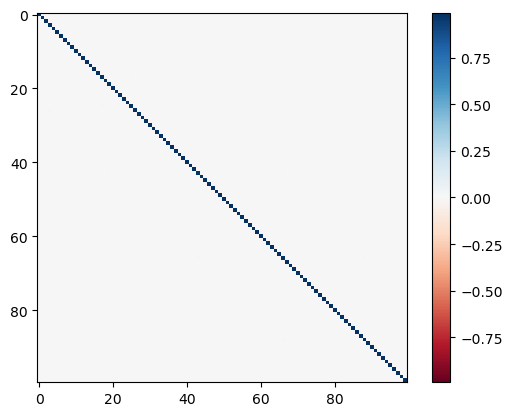

In [242]:
I = torch.eye(model.config.n_embd).to(model.dtype).to(model.device)
residual_add = mean_jacobian - I

residual_add_approx = low_rank_approximation(residual_add, rank = 50)
jacobian_approx = I + residual_add_approx
visualize_matrix(jacobian_approx)

In [243]:
relation_operator_approx = estimate.RelationOperator(
    model = model,
    tokenizer = tokenizer,
    relation = '{} is located in the country of',
    layer = 15,
    weight = jacobian_approx,
    bias = grad_dsc_corner
)

precision, ret_dict = evaluate.evaluate(
    relation_id="P17",
    relation_operator= relation_operator_approx,
    precision_at=3,
    validation_set= [
        (c["subject"], -1, c["target_true"]["str"]) 
        for c in model_predict_ok
    ]
)
precision

validating on 406 subject --> object associations


  0%|          | 0/406 [00:00<?, ?it/s]

0.8719211822660099